In [2]:
# Imports
import torch
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from datasets import load_dataset
from torch.utils.data import Dataset
from mingpt.trainer import Trainer
import matplotlib.pyplot as plt

set_seed(3407)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, max_length=1024):
        self.data = data
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token_id = 50256
        self.max_length = max_length
        self.vocab_size = self.tokenizer.vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the text and target
        text = self.data[idx]['text']
        
        # Tokenize the text
        tokens = self.tokenizer.encode(
            text, add_special_tokens=True, 
            max_length=self.max_length, 
            truncation=True, 
            return_tensors='pt', 
            padding=True
        )
      
        # Return the tokens and targets
        return tokens[:, :-1], tokens[:, 1:].clone()

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iteration time: {trainer.iter_dt * 1000:.2f}ms | iteration {trainer.iter_num} | train loss {trainer.loss.item():.5f}")

In [6]:
# Load in a sample of Red Pajama data
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", cache_dir='data')['train']
data = CustomDataset(dataset)

# Set up model
model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = data.vocab_size
model_config.block_size = data.max_length - 1
model_config.checkpoint = None
model = GPT(model_config)

number of parameters: 124.44M


In [7]:
# Configure training
train_config = Trainer.get_default_config()

train_config.learning_rate = 5e-4
max_iters = 1000
train_config.max_iters = max_iters+model.iter_num if model_config.checkpoint else max_iters
train_config.num_workers = 0
train_config.checkpoint_iters = 100
train_config.batch_size = 1

# Train
trainer = Trainer(train_config, model, data)
trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()

# Get loss from trainer and average over the checkpoint
losses = [a.detach().cpu() for a in trainer.curr_loss]
new_losses = np.mean(np.array(losses).reshape(-1, 100), axis=1)

running on device cuda
iteration time: 0.00ms | iteration 0 | train loss 10.98277
iteration time: 321.79ms | iteration 100 | train loss 7.92616
iteration time: 263.74ms | iteration 200 | train loss 8.00318
iteration time: 431.32ms | iteration 300 | train loss 7.94950
iteration time: 732.40ms | iteration 400 | train loss 7.87011
iteration time: 280.75ms | iteration 500 | train loss 7.75428
iteration time: 2264.46ms | iteration 600 | train loss 7.36327
iteration time: 602.66ms | iteration 700 | train loss 7.32879
iteration time: 1688.54ms | iteration 800 | train loss 9.69570
iteration time: 475.11ms | iteration 900 | train loss 9.48861


This is my loss graph, where iterations is in hundreds

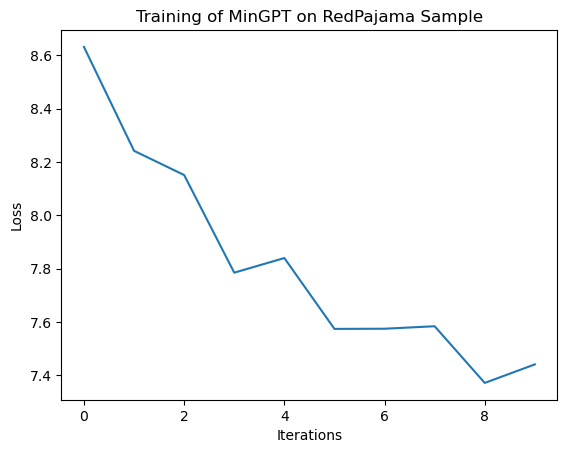

In [11]:
# Create a line plot
plt.plot(np.arange(len(new_losses)), new_losses)

# Set plot title and labels
plt.title('Training of MinGPT on RedPajama Sample')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Show the plot
plt.show()

Here are my results from running the lm-evaluation harness on a test!

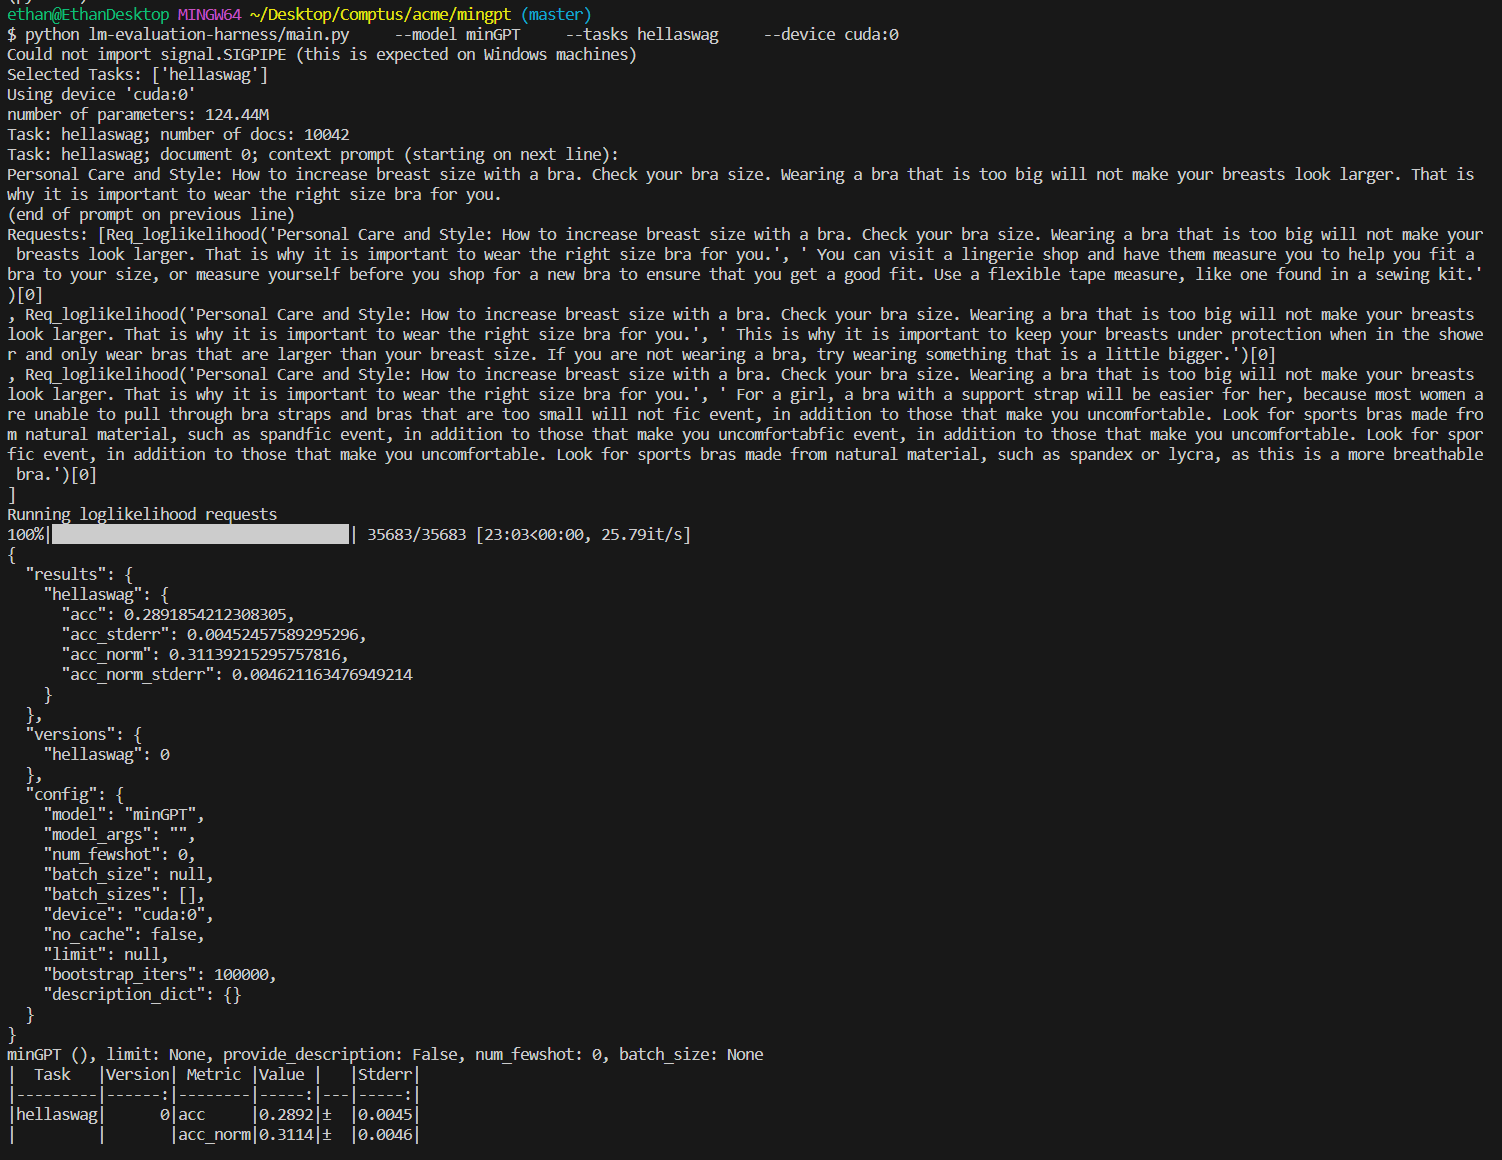

In [10]:
from IPython.display import Image
Image(filename="lm-eval_results.png")